## Clustering Example with PySpark

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib as plt
from numpy import array
from math import sqrt
from pyspark.sql import SQLContext
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import DenseVector
plt.style.use("ggplot")

---------------------------

In [57]:
# Create dataset, in practice we usually read from a database or filesystem like HDFS, S3 etc...
rdd = sc.parallelize([("A", 1, 1), ("B", 1, 0), ("C", 0, 2), ("D", 2, 4), ("E", 3, 5) ])
schema = ["id", "x", "y"]
dataset = sqlContext.createDataFrame(rdd, schema)

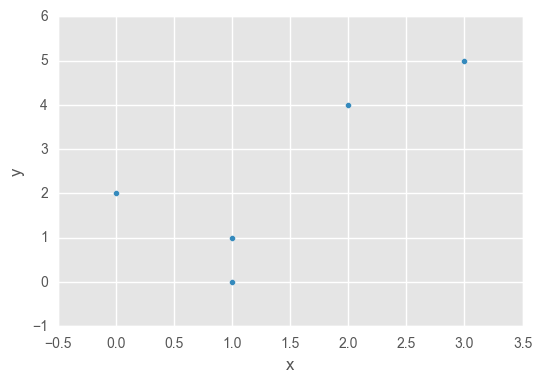

In [54]:
"""
- The goal is to find meaningful clusters from the dataset
- We will use k-means to do it
- In this case, k=2 could make sense according to the graph
- In practice there is more than five observations i.e. looking at the graph is not possible 
- A common way to identify the optimal "k" is to use the elbow method
"""
dataset.toPandas().plot(x="x", y="y", kind="scatter")
pass

In [5]:
# Create input data to have id and features as column
input_data = dataset.rdd.map(lambda x: (x[0], DenseVector(x[1:])))
input_df = sqlContext.createDataFrame(input_data, ["id", "features"])

In [6]:
# Check column types
input_df.columns

['id', 'features']

In [7]:
# Scale the data
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [8]:
scaler = standardScaler.fit(input_df)

In [9]:
scaled_df = scaler.transform(input_df)

In [10]:
scaled_df.first()

Row(id='A', features=DenseVector([1.0, 1.0]), features_scaled=DenseVector([0.8771, 0.4822]))

In [45]:
# Specify the k in k-means
kmeans = KMeans(k=2, seed=1, featuresCol="features_scaled", predictionCol="label")

In [46]:
model = kmeans.fit(scaled_df)

In [91]:
clusterCenters = model.clusterCenters()

In [92]:
clusterCenters

[array([ 0.58470535,  0.48224282]), array([ 2.19264505,  2.1700927 ])]

In [47]:
df_prediction = model.transform(scaled_df)

In [48]:
# Our data with assigned labels
df_prediction.collect()

[Row(id='A', features=DenseVector([1.0, 1.0]), features_scaled=DenseVector([0.8771, 0.4822]), label=0),
 Row(id='B', features=DenseVector([1.0, 0.0]), features_scaled=DenseVector([0.8771, 0.0]), label=0),
 Row(id='C', features=DenseVector([0.0, 2.0]), features_scaled=DenseVector([0.0, 0.9645]), label=0),
 Row(id='D', features=DenseVector([2.0, 4.0]), features_scaled=DenseVector([1.7541, 1.929]), label=1),
 Row(id='E', features=DenseVector([3.0, 5.0]), features_scaled=DenseVector([2.6312, 2.4112]), label=1)]

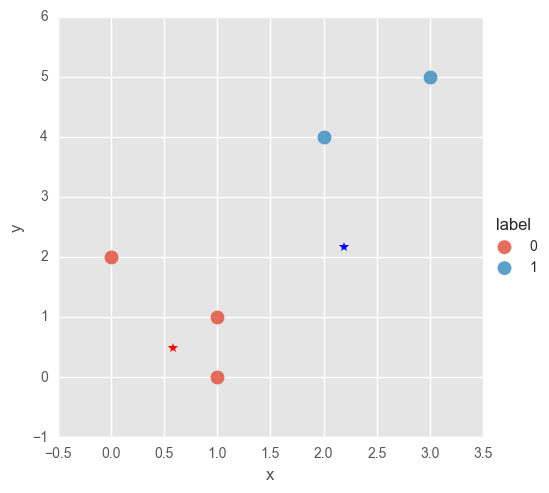

In [112]:
# Plot data along with the labels and cluster centers
data = pd.concat([dataset.toPandas(), df_prediction.toPandas().label], axis=1)
fig = sns.lmplot('x', 'y', data=data, hue='label', fit_reg=False, scatter_kws={"s": 100}, scatter = True)
fig.ax.plot([model.clusterCenters()[0][0]], [model.clusterCenters()[0][1]], "r*") # cluster center label = 0
fig.ax.plot([model.clusterCenters()[1][0]], [model.clusterCenters()[1][1]], "b*") # cluster center label = 1
pass